In [27]:
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


# 서울 전체 바운더리 생성 후 버퍼 500m 생성
seoul_boundary = gpd.read_file(
    r"C:\Users\bsh96\Documents\GitHub\Smart_Coffee\seoul_boundary.shp"
)
seoul_boundary_union = seoul_boundary.unary_union
seoul_boundary_gdf = gpd.GeoDataFrame(
    geometry=[seoul_boundary_union], crs=seoul_boundary.crs
)
# 버퍼 생성
seoul_buffer = seoul_boundary_gdf.buffer(500)
# 버퍼를 GeoDataFrame으로 변환
seoul_buffer_gdf = gpd.GeoDataFrame(
    geometry=seoul_buffer, crs=seoul_boundary.crs
)


C:\Users\bsh96\AppData\Local\Temp\ipykernel_24896\3058654666.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  seoul_boundary_union = seoul_boundary.unary_union


In [28]:
# 지하철 데이터 불러오기기

metro_df = pd.read_excel("data/전체_도시철도역사정보_20250417.xlsx", sheet_name="표준데이터 역사(전체)")
seoul_metro_with_date_df = pd.read_csv("data/서울교통공사_역사건축정보_20250310.csv", encoding="euc-kr")

# "역명"을 기준으로 준공연도 컬럼 추가
metro_df = metro_df.merge(
    seoul_metro_with_date_df[["역명", "준공연도"]],
    on="역명",
    how="left"
)
metro_df.head(5)

,역번호,역명,노선번호,노선명,영문역사명,한자역사명,환승역구분,환승노선번호,환승노선명,역위도,역경도,운영기관명,역사도로명주소,역사전화번호,데이터기준일자,준공연도
0,1816,간석역,I1101,경인선,Ganseok,間 石,일반역,NaN,NaN,37.464689,126.693408,한국철도공사,인천시 남동구 석정로 522-14,1588-7788,2025-04-08 00:00:00,NaN
1,1801,개봉역,I1101,경인선,Gaebong,開峰,일반역,NaN,NaN,37.494698,126.858504,한국철도공사,서울시 구로구 경인로 40길 47,1588-7788,2025-04-08 00:00:00,NaN
2,1813,구일역,I1101,경인선,Guil,九 一,일반역,NaN,NaN,37.496273,126.869599,한국철도공사,서울시 구로구 구일로 133,1588-7788,2025-04-08 00:00:00,NaN
3,1817,도원역,I1101,경인선,Dowon,桃 源,일반역,NaN,NaN,37.468604,126.642824,한국철도공사,인천시 동구 참외전로 245,1588-7788,2025-04-08 00:00:00,NaN
4,1823,도화역,I1101,경인선,Dohwa,道 禾,일반역,NaN,NaN,37.466154,126.668460,한국철도공사,인천시 남구 숙골로 24번길 9,1588-7788,2025-04-08 00:00:00,NaN


C:\Users\bsh96\AppData\Local\Temp\ipykernel_24896\3825223947.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\bsh96\AppData\Local\Temp\ipykernel_24896\3825223947.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


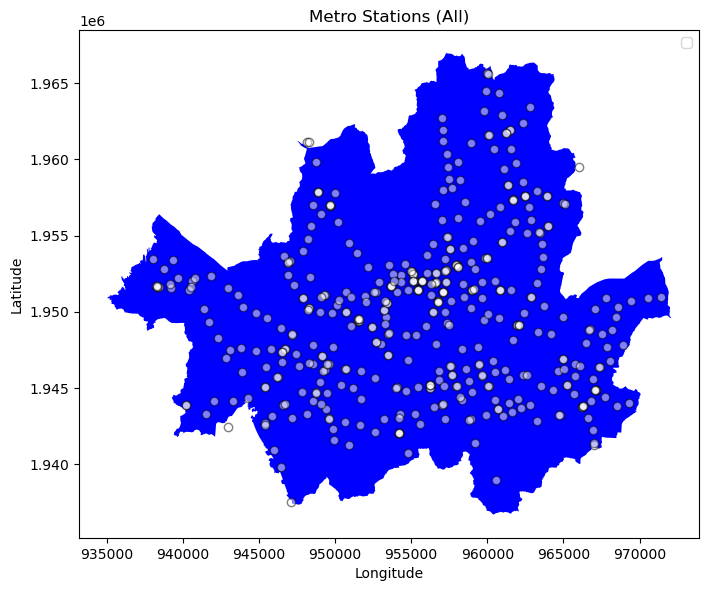

In [43]:


# '역위도', '역경도' 결측치 제거
metro_df_valid = metro_df.dropna(subset=['역위도', '역경도'])

# 좌표로 Point geometry 생성
# GeoDataFrame 생성 
metro_gdf = gpd.GeoDataFrame(
    metro_df_valid,
    geometry=gpd.points_from_xy(metro_df_valid['역경도'], metro_df_valid['역위도']),
    crs="EPSG:4326"  # WGS 84 좌표계
)
# metro_gdf의 좌표계를 seoul_buffer_gdf의 crs로 변환
metro_gdf = metro_gdf.to_crs(seoul_buffer_gdf.crs)

# seoul_buffer_gdf 내에 있는 역만 필터링
metro_gdf_in_buffer = metro_gdf[metro_gdf.within(seoul_buffer_gdf.iloc[0].geometry)]

seoul_buffer_gdf.head(3)


# metro_t_gdf = gpd.read_file("data/subway_statn_info.shp")
# metro_t_gdf.head(3)

# metro_gdf의 지하철역 위치를 시각화
fig, ax = plt.subplots(figsize=(8, 8))
seoul_boundary_gdf.plot(ax=ax, color='blue', markersize=10, label='Metro Stations')
metro_gdf_in_buffer.plot(ax=ax, color='white', edgecolor='black', alpha=0.5)
plt.legend()
plt.title("Metro Stations (All)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [44]:
# 카페 데이터 불러오기 및 GeoDataFrame 생성
seoul_cafe_df = pd.read_csv("data/cafe_open_at_2016_2024.csv", encoding="utf-8")

seoul_cafe_gdf = gpd.GeoDataFrame(
    seoul_cafe_df,
    geometry=gpd.points_from_xy(seoul_cafe_df["좌표정보x(epsg5174)"], seoul_cafe_df["좌표정보y(epsg5174)"]),
    crs="EPSG:5174"
)
# cafe_gdf의 좌표계를 grid_100m_pop_in_seoul과 맞추기
if seoul_cafe_gdf.crs != seoul_boundary_gdf.crs:
    cafe_gdf = seoul_cafe_gdf.to_crs(seoul_boundary_gdf.crs)



In [ ]:
from datetime import datetime
def is_alive(row, date_to_check):
    # type: (pd.Series, datetime) -> bool
    # 해당 일자에 영업중인지 확인하는 함수
    if row["영업상태명"] == "영업/정상":
        # 인허가일자가 date_to_check보다 이전인지 확인
        if datetime.strptime(row["인허가일자"], "%Y-%m-%d") > date_to_check:
            return False
        return True

    # 폐업하였더라도 3년이상 영업한경우는 생존으로 간주
    if row["영업상태명"] == "폐업":
        start_date = datetime.strptime(row["인허가일자"], "%Y-%m-%d")
        end_date = datetime.strptime(row["폐업일자"], "%Y-%m-%d")
        # datee_to_check 가 start_date와 end_date 사이에 있는지 확인
        if start_date <= date_to_check <= end_date:
            return True

    return False


closed_seoul_cafe_gdf = cafe_gdf[cafe_gdf["영업상태명"] == "폐업"]

proximity_metro_dists = []
for idx, row in closed_seoul_cafe_gdf.iterrows():
    center = row.geometry
    # metro_gdf 중 center와 거리가 가장 가까운 metro 역 찾기
    nearest_metro = metro_gdf_in_buffer.distance(center).idxmin()
    # 거리 계산
    nearest_metro_dist = metro_gdf_in_buffer.geometry[nearest_metro].distance(center)
    proximity_metro_dists.append(nearest_metro_dist)
    
    
    # close_date = datetime.strptime(row["폐업일자"], "%Y-%m-%d")


    

closed_seoul_cafe_gdf = closed_seoul_cafe_gdf.copy()
closed_seoul_cafe_gdf["proximity_metro_dist"] = proximity_metro_dists
closed_seoul_cafe_gdf.head(20)

,관리번호,사업장명,좌표정보x(epsg5174),좌표정보y(epsg5174),영업상태명,인허가일자,폐업일자,geometry,proximity_metro_dist
0,3010000-101-2022-00422,매머드커피익스프레스 장충동먹자골목점,200479.632428,451095.901956,폐업,2022-11-28,2024-11-27,POINT (956390.498 1951535.102),292.491441
1,3010000-101-2016-00386,만랩커피 을지로입구역점,198217.309167,451709.930986,폐업,2016-12-05,2022-11-23,POINT (954132.33 1952160.882),253.891547
2,3010000-101-2007-00116,이디야YTN점,197504.865051,450658.592453,폐업,2007-04-18,2023-09-07,POINT (953414.594 1951113.737),416.823115
3,3010000-101-2007-00024,이디야,197786.161407,451886.574199,폐업,2007-01-18,2022-06-24,POINT (953702.29 1952339.742),160.385344
30,3100000-101-2021-00048,더 벤티,205503.722304,461314.576463,폐업,2021-02-03,2024-06-03,POINT (961466.804 1961723.008),230.749155
31,3100000-101-1997-01867,이디야 에스프레소,205430.356783,461479.613300,폐업,1997-04-07,2023-01-31,POINT (961394.345 1961888.368),100.152535
32,3100000-101-2011-00165,이디야,204772.367380,464080.593905,폐업,2011-07-01,2018-03-19,POINT (960750.444 1964491.794),150.735280
33,3100000-101-2023-00202,감성커피 노원롯데캐슬점,206799.020098,462509.638446,폐업,2023-07-03,2024-07-03,POINT (962767.927 1962910.703),513.509332
51,3160000-101-2007-00206,빽다방(구로삼성IT점),190612.779366,442662.421914,폐업,2007-06-19,2017-03-30,POINT (946482.852 1943157.208),643.449710
68,3040000-101-1981-02511,이디야(중곡역점),207333.639771,451464.267097,폐업,1981-01-22,2023-07-25,POINT (963243.7 1951866.98),65.949743


폐업한 카페의 지하철역과의 거리 기술통계:
count     595.000000
mean      386.699928
std       324.034779
min         7.971484
25%       171.322540
50%       298.738953
75%       511.108845
max      2537.207158
Name: proximity_metro_dist, dtype: float64


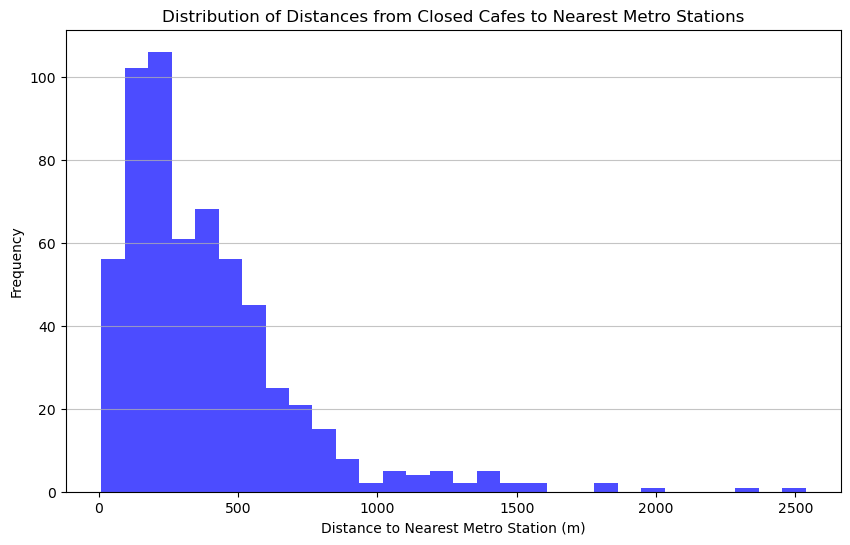

In [48]:

# 살아있는 카페와 폐업한 카페로 분리
closed_seoul_cafe_gdf_nearby_count = closed_seoul_cafe_gdf["proximity_metro_dist"]


# 기술통계 출력
print("폐업한 카페의 지하철역과의 거리 기술통계:")
print(closed_seoul_cafe_gdf_nearby_count.describe())
# 폐업한 카페의 지하철역과의 거리 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(closed_seoul_cafe_gdf_nearby_count, bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Distances from Closed Cafes to Nearest Metro Stations")
plt.xlabel("Distance to Nearest Metro Station (m)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()



In [49]:
closed_seoul_cafe_gdf.drop(columns="geometry").to_csv("cafe_with_nearby_metro_dist.csv", index=False, encoding="utf-8")